# Machine Learning Approach to Used Car Pricing Modeling
by Gene Ichinose
Nov 2022

# Business Understanding

The objective of this study is to determine what key factors drives the price of a used car. The business requirements are from the client who owns a used car dealership which requires information about what consumers value in a used car and information useful for pricing trade-ins as an alternative to kbb.com. The goal is to develop a set of factors that drive up or down a value of a car in dollar values and a model useful for predicting the price of a vehicle based on these factors.


The plan involves:

<ol type="1">
    <li><a href="#dataunderstanding">Data understanding</a></li>
    <ol type="A">
        <li>An inventory of the dataset</li>
        <li>Identify which features are continuous and numerical versus which are discrete and categorical</li>
        <li>Explore the unique range of categorical data</li>
    </ol>

<li><a href="#datapreparation">Data Preparation</a></li>
    <ol type="A">
        <li>Window the appropriate ranges of the features and targets</li>
        <li>Removal of the data with missing key features</li>
        <li>Removal of data outliers as a form of data quality control</li> 
        <li>Removal of duplicates</li> 
        <li>Logarithmic and exponential transformations of the target to achieve normal distributions</li>
        <li>Identify the features and target for regression</li>
        <li>Split dataset for training and teseting</li>
    </ol>
    
<li><a href="#modeling">Modeling</a></li>
    <ol type="A">
        <li>Set up a pipeline workflow to handle the transformations and linear regressions</li>
        <li>Encoding categorical data using ordinal and one hot encoding</li>
        <li>We will compare RIDGE and LASSO linear regression models</li>
        <li>Set up a grid search to determine the best regularization hyperparameter alpha. The regularization approach allows us to include many features without overfitting.</li>
        <li>Examination of the observed and predicted target "independent" variables</li>
        <li>Cross validation to check for overfitting</li>
    </ol>
<li><a href="#evaluation">Evaluation</a></li>
    <ol type="A">
        <li><a href="#coefficients">Analysis of Resulting Coefficients</a></li>
        <li><a href="#importance">Importance of Coefficients</a></li>
        <li><a href="#transform">Transform Target Regressor Test</a></li>
        <li><a href="#variability">Coefficient Importance and Variability Analysis</a></li>
        <li><a href="#residualanalysis">Residual Analysis</a></li>
    </ol>
        
 <li><a href="#deployment">Deployment</a></li>
    <ol type="A">
        <li><a href="#direct">Direct application: Comparison of the regression model to kbb.com</li> 
        <li><a href="#keyfindings">Key findings</a></li>
        <li><a href="#implications">Business implications</a></li>
        <li><a href="#future">Future directions</a></li>
    <ol>
</ol>

## <a name="dataunderstanding">Data understanding</a>
<P>
Some observations from initially exploring the dataset, 

1. There are too many makes (41) and models (9529) of vehicles to incorporate them into the initial regression analysis. We will only focus on the physical characteritics of the vehicles.


2. The dataset includes vehicles from all 50 states and DC. 


In future analysis, it would be interesting to look at the residuals of this analysis as a function of make, model, and state or region to see if there are any trends that warrent further inclusion in a more detailed analysis.

3. All other categorical data (cylinders, fuel, title_status, transmission, drive, size, type) appear to have no natural ordering/ranking therefore best handled using one-hot-encoding.  The category (condition) may have rank and therefore we will take a deeper look later.


4. There appears to be vehicles dating back to 1900.  We will need to check odometer, year and determine how to handle special cases like antiques. These will need to be removed to focus on developing a mainstream commercial model for used cars.


5. Before data preparation (windowing), we observe no correlation between year or odometer with price.  See later recalculation or correlation results after windowing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the dataset
df = pd.read_csv('vehicles.csv')

In [3]:
# drop columns that are too specific to each data point and would have little value in the regression
# also remove nan's
#
df.drop(columns=['id','VIN','region'], inplace=True)
df.dropna(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79195 entries, 31 to 426836
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         79195 non-null  int64  
 1   year          79195 non-null  float64
 2   manufacturer  79195 non-null  object 
 3   model         79195 non-null  object 
 4   condition     79195 non-null  object 
 5   cylinders     79195 non-null  object 
 6   fuel          79195 non-null  object 
 7   odometer      79195 non-null  float64
 8   title_status  79195 non-null  object 
 9   transmission  79195 non-null  object 
 10  drive         79195 non-null  object 
 11  size          79195 non-null  object 
 12  type          79195 non-null  object 
 13  paint_color   79195 non-null  object 
 14  state         79195 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 9.7+ MB


In [5]:
# Explore the range of unique values that are categorical
#
print(df['year'].sort_values().unique())
maker = df['manufacturer'].sort_values().unique()
print(f'number of manufacturers: {len(maker)}')
print(np.vstack(maker))

models = df['model'].unique()
print(f'number of models: {len(models)}')
print(models)

print(df['condition'].unique())
print(df['cylinders'].unique())
print(df['fuel'].unique())
print(df['title_status'].unique())
print(df['transmission'].unique())
print(df['drive'].unique())
print(df['size'].unique())
print(df['type'].unique())
print(df['paint_color'].unique())

states = df['state'].unique()
print(f'number of states: {len(states)}')
print(states)

[1900. 1905. 1913. 1918. 1923. 1924. 1925. 1926. 1927. 1928. 1929. 1930.
 1931. 1932. 1933. 1934. 1935. 1936. 1937. 1938. 1939. 1940. 1941. 1942.
 1944. 1946. 1947. 1948. 1949. 1950. 1951. 1952. 1953. 1954. 1955. 1956.
 1957. 1958. 1959. 1960. 1961. 1962. 1963. 1964. 1965. 1966. 1967. 1968.
 1969. 1970. 1971. 1972. 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980.
 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992.
 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004.
 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016.
 2017. 2018. 2019. 2020. 2021. 2022.]
number of manufacturers: 41
[['acura']
 ['alfa-romeo']
 ['aston-martin']
 ['audi']
 ['bmw']
 ['buick']
 ['cadillac']
 ['chevrolet']
 ['chrysler']
 ['datsun']
 ['dodge']
 ['ferrari']
 ['fiat']
 ['ford']
 ['gmc']
 ['harley-davidson']
 ['honda']
 ['hyundai']
 ['infiniti']
 ['jaguar']
 ['jeep']
 ['kia']
 ['land rover']
 ['lexus']
 ['lincoln']
 ['mazda']
 ['mercedes-benz']
 ['merc

In [6]:
df[['price', 'year', 'odometer']].corr()

,price,year,odometer
price,1.000000,-0.001535,0.000620
year,-0.001535,1.000000,-0.091326
odometer,0.000620,-0.091326,1.000000


## <a name="datapreparation">Data Preparation</a>

Based on the precursory examination of the data, we select cars that are within a reasonable range of years, odometer milage, and target price.  

1. Dealers are not going to expend resources (i.e., time, paperwork, evaluation, sales floor space) on vehicles that will only sell for less than \\$ 2000. 

2. Customers can purchase almost any new car greater than \\$ 50k. Above \\$ 50k may involve special antiques, or specialized modified vehicles that will require additional features not available in this dataset

3. Customers may not want to purchase cars with over 150000 mi. Many parts will be worn and need replacing. The same applies to years where most consumers will not want a car older than 15 years (as of 2022) as parts will be aged and need replacing. Also, cars with less than 1000 mi are considered new cars in this study and removed.  

4. Remove cases with title_status = "parts only" not going to be sold as used cars. Title status as salvaged and rebuilt are included. These may be vehicles coming in from disaster zones (floods, hailstorms, or hurricanes)

5. The category 'condition' has a natural ranking. 

6. We find that as cars age, they also increase in odometer milage. We therefore apply filter to remove outliers by year. These may be errors in recording price, gifts from relatives or friends, and edge cases like antiques or heavily modified specialized vehicles.

7. After windowing, we observe that newer cars have a ~0.5 moderate positive correlation with price while odometer has a ~0.5 moderate negative correlation. This is more logically expected compared to the initial correlation that indicated no correlation with prices. 

8. After a few regression runs we could not fit the price target for the higher price ranges. We find that the distribution of price is not normal.  There is not enough data at the low and high ends with most of the data in the mid-price range.  This is causing misfitting.  We decided to take the log10 of the price-target and that changes the distribution of the price-target. 

9. In addition to transforming the price using log10, we finally selected the following features: 
    ['year', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type']
    
    After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with sklearn.

In [7]:
# window the data
#
df_clean = df.query(' \
    (2000 < price < 50000) & \
    ( 2007 < year < 2023 ) & \
    ( 1000 < odometer < 150000 ) & \
    title_status != "parts only" \
')

In [8]:
# fix the categorical ranking for condition
#
print(df_clean['condition'].unique())
df_clean['condition'] = df_clean['condition'].astype('category')
df_clean['condition'] = df_clean['condition'].cat.set_categories(
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'], ordered=True)

['excellent' 'good' 'like new' 'new' 'fair' 'salvage']


In [9]:
# remove outliers using 5-95% window on price per year
#
df_filtered = pd.DataFrame(columns=df_clean.columns)
yrs_lst = df_clean['year'].sort_values().unique()

for y in yrs_lst:
    n = df_clean.query('year == @y')['price'].count()
    q_low = df_clean.query('year == @y')['price'].quantile(0.05)
    q_hi  = df_clean.query('year == @y')['price'].quantile(0.95)
    df_tmp = df_clean.query( 'year == @y & ( @q_low < price <= @q_hi )') 
    nf = df_tmp.price.count()
    df_filtered = pd.concat( [df_tmp, df_filtered], axis=0, ignore_index=True )
    print(f'count= {n} filtered= {nf} year={y} q_low={q_low} q_hi={q_hi}')

count= 2553 filtered= 2292 year=2008.0 q_low=3500.0 q_hi=27990.0
count= 1960 filtered= 1759 year=2009.0 q_low=3900.0 q_hi=23000.0
count= 2456 filtered= 2212 year=2010.0 q_low=4495.0 q_hi=22990.0
count= 3046 filtered= 2740 year=2011.0 q_low=4950.0 q_hi=27990.0
count= 3600 filtered= 3228 year=2012.0 q_low=5000.0 q_hi=32902.499999999985
count= 4330 filtered= 3891 year=2013.0 q_low=5900.0 q_hi=29995.0
count= 4118 filtered= 3708 year=2014.0 q_low=6495.0 q_hi=34500.0
count= 3947 filtered= 3548 year=2015.0 q_low=7000.0 q_hi=43000.0
count= 3263 filtered= 2930 year=2016.0 q_low=8495.0 q_hi=41999.9
count= 3033 filtered= 2731 year=2017.0 q_low=9780.0 q_hi=41860.0
count= 2351 filtered= 2125 year=2018.0 q_low=10962.5 q_hi=45995.0
count= 1428 filtered= 1286 year=2019.0 q_low=14635.0 q_hi=46999.0
count= 655 filtered= 589 year=2020.0 q_low=16210.0 q_hi=46659.99999999999
count= 56 filtered= 53 year=2021.0 q_low=23499.25 q_hi=49995.0


In [10]:
## fix the price column back to float, somehow got converted to object
df_filtered['price'] = df_filtered['price'].astype(float)

In [11]:
# df_filtered.info()
df_filtered.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,40900.0,2021.0,toyota,tacoma 4wd,good,6 cylinders,gas,1582.0,clean,automatic,4wd,full-size,truck,silver,al
1,40900.0,2021.0,toyota,tacoma 4wd,good,6 cylinders,gas,1582.0,clean,automatic,4wd,full-size,truck,silver,al
2,40900.0,2021.0,toyota,tacoma 4wd,good,6 cylinders,gas,1582.0,clean,automatic,4wd,full-size,truck,silver,al
3,31500.0,2021.0,toyota,rav4,like new,4 cylinders,gas,2500.0,lien,automatic,4wd,mid-size,SUV,silver,ak
4,26971.0,2021.0,toyota,camry se awd,like new,4 cylinders,gas,3047.0,clean,automatic,4wd,mid-size,sedan,red,az


In [12]:
# for some reason, we accidentally introduced 6830 duplicates in the filtering process
#  identified after post filtering quality inspection
#
df_filtered.duplicated().sum()

6830

In [13]:
# removed dups
#
df_filtered.drop_duplicates(inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26262 entries, 0 to 33091
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price         26262 non-null  float64 
 1   year          26262 non-null  float64 
 2   manufacturer  26262 non-null  object  
 3   model         26262 non-null  object  
 4   condition     26262 non-null  category
 5   cylinders     26262 non-null  object  
 6   fuel          26262 non-null  object  
 7   odometer      26262 non-null  float64 
 8   title_status  26262 non-null  object  
 9   transmission  26262 non-null  object  
 10  drive         26262 non-null  object  
 11  size          26262 non-null  object  
 12  type          26262 non-null  object  
 13  paint_color   26262 non-null  object  
 14  state         26262 non-null  object  
dtypes: category(1), float64(3), object(11)
memory usage: 3.0+ MB


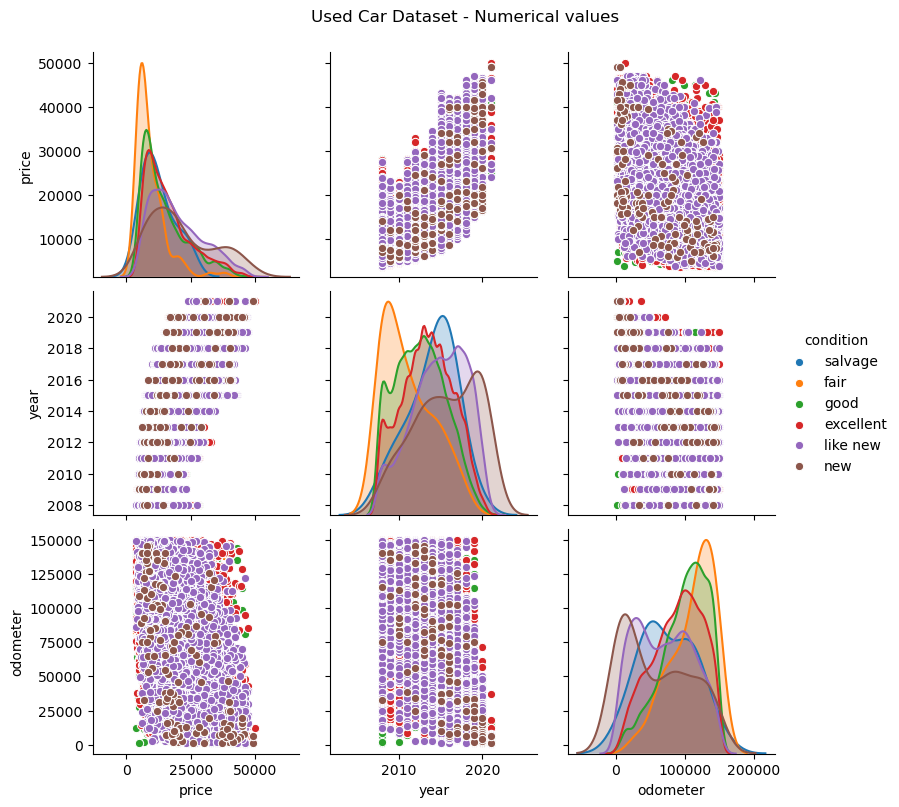

In [14]:
### examine the numerical values for correlation between variables
###
g = sns.pairplot(df_filtered, hue='condition')
g.fig.suptitle('Used Car Dataset - Numerical values', y=1.05)
plt.show()

In [15]:
### calculate correlation coeffients
###
df_filtered[['price', 'year', 'odometer']].corr()

,price,year,odometer
price,1.000000,0.627779,-0.471256
year,0.627779,1.000000,-0.590513
odometer,-0.471256,-0.590513,1.000000


We now observe from the windowed and filtered dataset that used cars have a weak +0.6 positive correlation with price while odometer has a weak -0.5 negative correlation

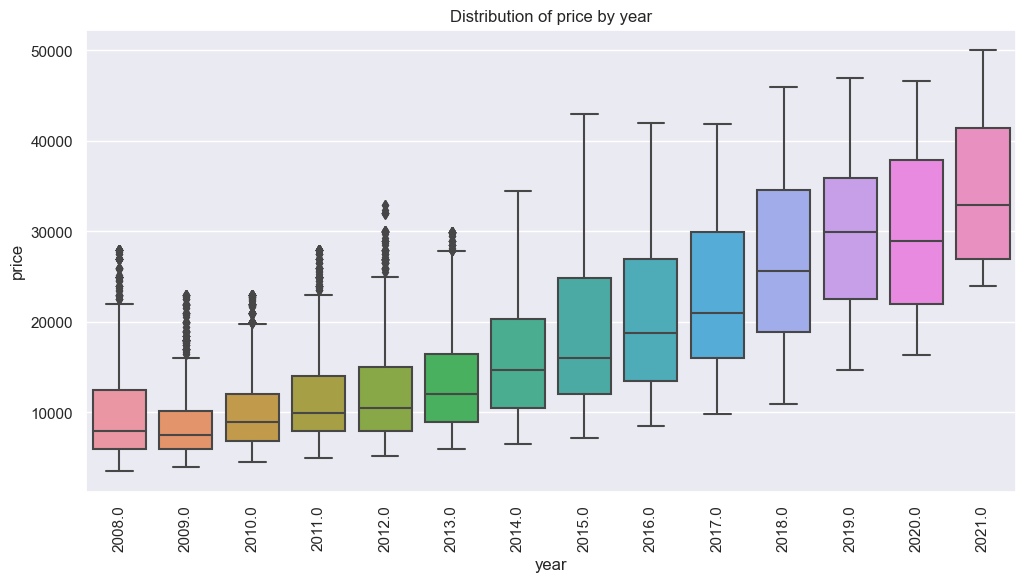

In [16]:
## make box plot to show behavior of car price by year 
##
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=df_filtered, x='year', y='price').set(title='Distribution of price by year')
ax = plt.xticks(rotation=90)
plt.show()

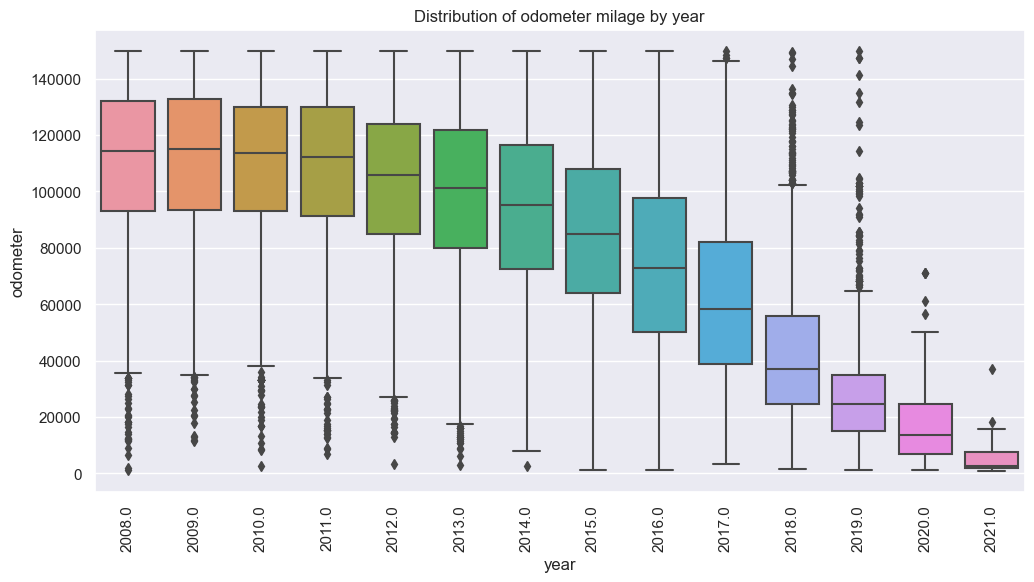

In [17]:
## odometer mileage by year
##
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=df_filtered, x='year', y='odometer').set(title='Distribution of odometer milage by year')
ax = plt.xticks(rotation=90)
plt.show()

After windowing reasonable ranges and filtering outliers, the two box plots above show that price and odometer now have smooth trend with year. Price is increasing and odometer is inverse relation with time. This is logical expectation. Without data cleaning, these trends were difficult to see as shown with the changes in correlation. Note that the price of used cars flattens out below \\$ 10,000 after an age of 10 years (i.e., 2011 at the time of this report). At about this time, the odometer mileage also flattens out around 110,000 miles. 

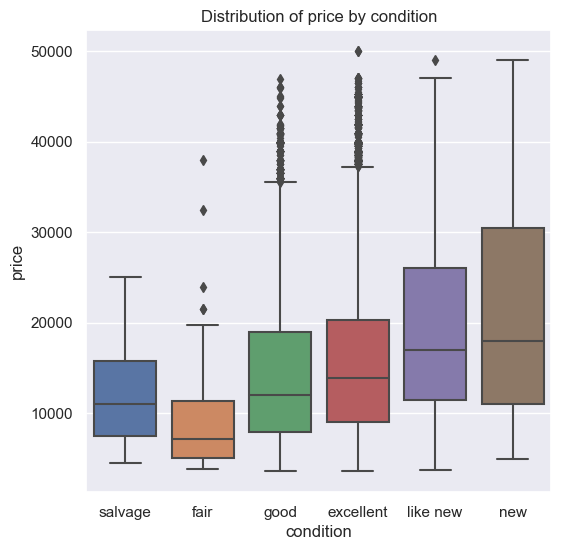

In [18]:
### Verify relation between price and condition category
###
sns.set(rc={'figure.figsize':(6,6)})
sns.boxplot(data=df_filtered, x='condition', y='price').set(title='Distribution of price by condition')
plt.show()

Above is the justification for ranking condition by price. Note the general trend between fair and new with price. The exception is with salvage which may include damaged cars in traffic accidents or cars damaged in natural disasters.  The severity of the damage may vary significantly and requires additional information to better resolve this category. 

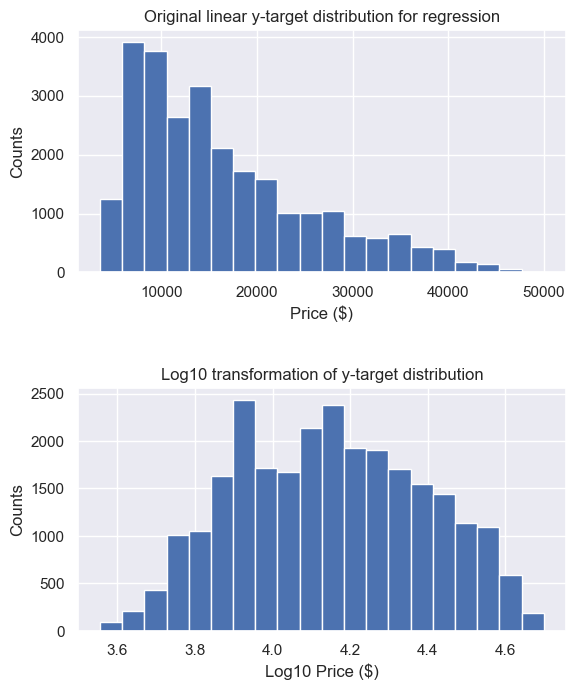

In [19]:
# compare original distribution of y-target price values with
#  log10(y-target) transformed values
#
fig, axs = plt.subplots(2, 1, figsize=(7,8))
fig.tight_layout(pad=5.0)

axs[0].hist( df_filtered['price'], bins=20)
axs[0].set_xlabel('Price ($)')
axs[0].set_ylabel('Counts')
axs[0].set_title('Original linear y-target distribution for regression')

axs[1].hist( np.log10(df_filtered['price']), bins=20)
axs[1].set_xlabel('Log10 Price ($)')
axs[1].set_ylabel('Counts')
axs[1].set_title('Log10 transformation of y-target distribution')
plt.show()

Above, log10 transform of the price-target is now more normal distribution.  

In [20]:
# these are the final features selected for regression analysis
#
features = ['year', 'condition', 'cylinders', 'fuel', 'odometer', 
            'title_status', 'transmission', 'drive', 'size', 'type']

In [21]:
# original runs using linear y-target did not fit data, tried taking log10(y)
# tested this using TransformTargetRegressor later
#
X = df_filtered[features]
#y = df_filtered['price']
y = np.log10( df_filtered['price'] )
# X.info()
# y.describe()

In [22]:
#### split dataset 70/30, hold-out 30% of dataset for subsequent testing
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
print(X_train.shape)
print(X_test.shape)

(18383, 10)
(7879, 10)


## <a name="modeling">Modeling</a>

We first perform Ridge regression and compare results with LASSO regression method.  The MSE fits are similar between Ridge and LASSO, however, there are some differences in the coefficients. The misfit between observed and predicted price are improved with using the log10 transform on price.  The pipeline workflow allows for grid search for the hyperparameter alpha which controls the regularization. The low regularization (1.2 for Ridge and 1e-5 for LASSO) indicates that most of the coefficients are contributing to the model.  

We use 5-fold cross validation to check for over-fitting.  The MSE for each fold is close to the mean indicating that overfitting is controlled.  

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [24]:
#### create column transformer for pipeline workflow
#
column_trans = make_column_transformer(
    (StandardScaler(), ['year', 'odometer']),
    (OneHotEncoder(handle_unknown='ignore'), ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type'] ),
    (OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
    remainder='passthrough', verbose_feature_names_out=False )       

In [25]:
### Setup Ridge regression pipeline workflow and grid search for hyperparameter alpha-regularization
###
ridge_param_dict = {'ridge__alpha': np.logspace(-5, 5, 50)}
pipe = Pipeline([
    ('transformer', column_trans),
    ('ridge', Ridge())
])
grid = GridSearchCV( pipe, param_grid = ridge_param_dict )

In [26]:
grid.fit( X_train, y_train )

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['salvage...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])})

In [27]:
## get the best model from grid search
##
best_model = grid.best_estimator_
best_alpha = grid.best_params_
best_alpha_str=(f'Optimal alpha: {list(best_alpha.values())[0].round(3)}')
train_mse = mean_squared_error(y_train, best_model.predict(X_train))
test_mse = mean_squared_error(y_test, best_model.predict(X_test))
best_mse_str=(f'MSE: Training={train_mse: .4f}, Test={test_mse: .4f}')
train_mae = median_absolute_error( y_train, best_model.predict(X_train) )
test_mae = median_absolute_error( y_train, best_model.predict(X_train) )
best_mae_str=(f'MAE: Training={train_mae: .4f}, Test={test_mae: .4f}')
print(best_mae_str)
print(best_mse_str)
print(best_alpha_str)

MAE: Training= 0.0708, Test= 0.0708
MSE: Training= 0.0120, Test= 0.0119
Optimal alpha: 3.237


In [28]:
#### Setup LASSO regression pipeline workflow and grid search for hyperparameter alpha-regularization
####
lasso_param_dict = { 'lasso__alpha' : np.logspace(-5, 5, 50)}
pipe2 = Pipeline([
    ('transformer', column_trans),
    ('lasso', Lasso())
])
grid2 = GridSearchCV( pipe2, param_grid = lasso_param_dict )

In [29]:
grid2.fit( X_train, y_train )

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['salvage...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])})

In [30]:
## get the best model from grid search
##
best_model2 = grid2.best_estimator_
best_alpha2 = grid2.best_params_
best_alpha_str2=(f'Optimal alpha: {list(best_alpha2.values())[0].round(5)}')

train_mse = mean_squared_error(y_train, best_model2.predict(X_train))
test_mse = mean_squared_error(y_test, best_model2.predict(X_test))
best_mse_str2=(f'MSE: Training={train_mse: .4f}, Test={test_mse: .4f}')

train_mae = median_absolute_error( y_train, best_model2.predict(X_train) )
test_mae = median_absolute_error( y_train, best_model2.predict(X_train) )
best_mae_str2=(f'MAE: Training={train_mae: .4f}, Test={test_mae: .4f}')

print(best_mae_str2)
print(best_mse_str2)
print(best_alpha_str2)

MAE: Training= 0.0708, Test= 0.0708
MSE: Training= 0.0120, Test= 0.0119
Optimal alpha: 3e-05


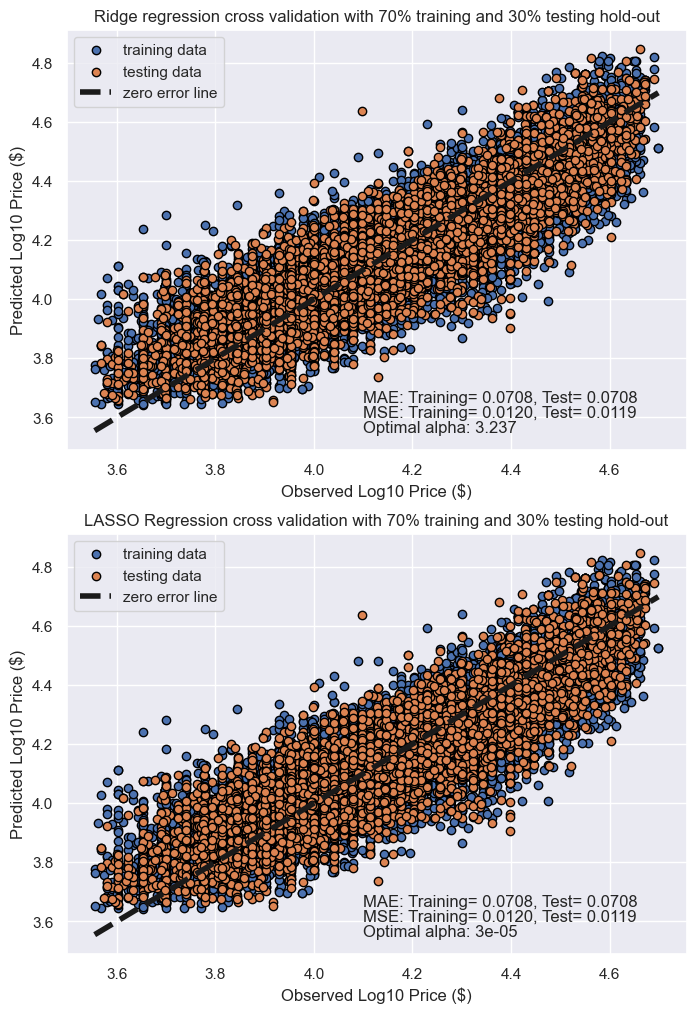

In [31]:
# Residual Plot, compare observed and predicted price from two regression models
#
fig, axes = plt.subplots(2, 1, figsize=(8,12))

axes[0].scatter(y_train, best_model.predict(X_train), edgecolors=(0, 0, 0), label='training data')
axes[0].scatter(y_test, best_model.predict(X_test), edgecolors=(0, 0, 0), label='testing data')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4, label='zero error line')
axes[0].set_xlabel("Observed Log10 Price ($)")
axes[0].set_ylabel("Predicted Log10 Price ($)")
axes[0].set_title("Ridge regression cross validation with 70% training and 30% testing hold-out")
axes[0].text(4.1, 3.55, best_alpha_str)
axes[0].text(4.1, 3.60, best_mse_str)
axes[0].text(4.1, 3.65, best_mae_str)
axes[0].legend()

axes[1].scatter(y_train, best_model2.predict(X_train), edgecolors=(0, 0, 0), label='training data')
axes[1].scatter(y_test, best_model2.predict(X_test), edgecolors=(0, 0, 0), label='testing data')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4, label='zero error line')
axes[1].set_xlabel("Observed Log10 Price ($)")
axes[1].set_ylabel("Predicted Log10 Price ($)")
axes[1].set_title("LASSO Regression cross validation with 70% training and 30% testing hold-out")
axes[1].text(4.1, 3.55, best_alpha_str2)
axes[1].text(4.1, 3.60, best_mse_str2)
axes[1].text(4.1, 3.65, best_mae_str2)
axes[1].legend()
plt.show()

Modeling: Cross Validation to check for overfitting

In [32]:
### Cross Validation Ridge 
###
cv_scores = cross_val_score(grid, X, y, cv = 5 )
# %store cv_scores

In [33]:
# %store -r cv_scores
print('Cross validation scores (5 folds): {}'.format(cv_scores))
print('The average cross validation score (5 folds): {}'.format(np.mean(cv_scores)))

Cross validation scores (5 folds): [0.59535057 0.70884698 0.67682925 0.61689323 0.55989771]
The average cross validation score (5 folds): 0.6315635491133533


In [34]:
### Cross Validation LASSO
###
cv_scores2 = cross_val_score( grid2, X, y, cv = 5 )
# %store cv_scores2

In [35]:
# %store -r cv_scores2
print('Cross validation scores (5 folds): {}'.format(cv_scores2))
print('The average cross validation score (5 folds): {}'.format(np.mean(cv_scores2)))

Cross validation scores (5 folds): [0.59819455 0.70907338 0.67712465 0.61670888 0.55883511]
The average cross validation score (5 folds): 0.6319873143125256


Here, we built a number of different regression models with the price as the target. In building our models, we  explored different parameters and cross-validated your models to ensure there is little to no overfitting.

## <a name="evaluation">4. Evaluation</a>

### <a name="coefficients">4.(A) Evaluation-Analysis of Resulting Coefficients</a>

In [36]:
### get coef from regression and column transformer and create a dataframe
###
feature_columns = best_model.named_steps["transformer"].get_feature_names_out()

coefs = pd.DataFrame( best_model.named_steps["ridge"].coef_,
                    columns=['coefficients'], 
                    index=feature_columns )

coefs_sorted = coefs.sort_values('coefficients', ascending=False)
coefs_sorted['coefficients'] = coefs_sorted.coefficients.round(5)
# coefs_sorted

In [37]:
### get coef from regression and column transformer and create a dataframe
###
feature_columns = best_model2.named_steps["transformer"].get_feature_names_out()

coefs2 = pd.DataFrame( best_model2.named_steps["lasso"].coef_,
                    columns=['coefficients'], 
                    index=feature_columns )

coefs2_sorted = coefs2.sort_values('coefficients', ascending=False)
coefs2_sorted['coefficients'] = coefs2_sorted.coefficients.round(5)
# coefs2_sorted

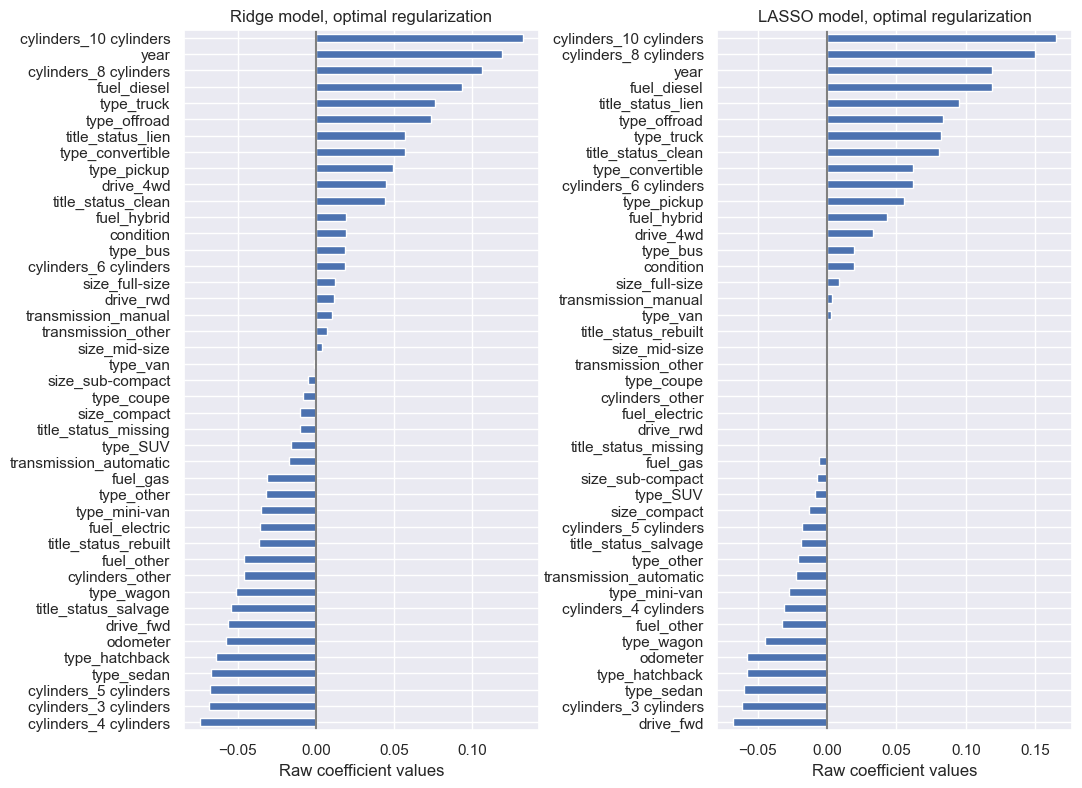

In [38]:
### plot coef from regression and column transformer 
###
coefs_sorted = coefs_sorted.sort_values('coefficients', ascending=True)
coefs2_sorted = coefs2_sorted.sort_values('coefficients', ascending=True)

fig, axes = plt.subplots(1,2,figsize=(12,10))
fig.tight_layout(pad=8)

coefs_sorted.plot.barh(ax=axes[0], legend=False )
axes[0].set_title("Ridge model, optimal regularization")
axes[0].axvline(x=0, color=".5")
axes[0].set_xlabel("Raw coefficient values")

coefs2_sorted.plot.barh(ax=axes[1], legend=False )
axes[1].set_title("LASSO model, optimal regularization")
axes[1].axvline(x=0, color=".5")
ax = axes[1].set_xlabel("Raw coefficient values")

The Ridge and LASSO regression models resulted in similar ordering of coefficients and resulting weights. We observe that year has a high positive weight with log10-price and odometer has a strong negative weight as expected in the correlation analysis.  From the categorical coefficients we see that trucks, offroad, pickup vehicles are weighted higher.  Fun or more powerful vehicles like those with 4wd, and convertibles also have higher ranking positive coefficients.   For the negative factors, lower power, economy vehicles rank lower. The fuel hybrid category has positive coefficients while fuel gas category is lower.  It is interesting that electric vehicles still rank lower, and it would be interesting if the higher gas prices in 2021-2022 due to inflation has changed electric vehicle prices. 

### <a name="importance">4.(B) Evaluation - Importance of Coefficients</a>

In [39]:
## for Ridge Regression, compute the importance of coefs using permutation_importance()
##
r = permutation_importance( grid, X_train, y_train, n_repeats=10, random_state=32 )
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<16}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year            0.484 +/- 0.006
cylinders       0.164 +/- 0.002
odometer        0.113 +/- 0.001
type            0.082 +/- 0.002
drive           0.074 +/- 0.001
title_status    0.017 +/- 0.001
fuel            0.014 +/- 0.001
condition       0.006 +/- 0.000
size            0.002 +/- 0.000
transmission    0.001 +/- 0.000


In [40]:
### for LASSO, compute the importance of coefs using permutation_importance()
###
r2 = permutation_importance( grid2, X_train, y_train, n_repeats=10, random_state=32 )
for i in r2.importances_mean.argsort()[::-1]:
    if r2.importances_mean[i] - 2 * r2.importances_std[i] > 0:
        print(f"{X.columns[i]:<16}"
              f"{r2.importances_mean[i]:.3f}"
              f" +/- {r2.importances_std[i]:.3f}")

year            0.485 +/- 0.006
cylinders       0.165 +/- 0.002
odometer        0.113 +/- 0.002
type            0.082 +/- 0.002
drive           0.074 +/- 0.001
title_status    0.017 +/- 0.001
fuel            0.014 +/- 0.001
condition       0.006 +/- 0.000
size            0.002 +/- 0.000
transmission    0.001 +/- 0.000


There are no differences between Ridge and LASSO regression models in coefficient importance's.  The coefficients year, cylinders, and odometer were the most important coefficients.

### <a name="transform">4.(C) Evaluation - TransformedTargetRegressor test</a>

We were curious in using TransformedTargetRegressor and Ridge model (at optimal alpha=0.29) to compare with previous regression results with manually taking the log10(y) transformation. Here we also performed an additional analysis of coefficient importance and variability.  We confirm that TransformedTargetRegressor is equivalent with transforming the y-target using log10(y) and 10**(y).  

In [41]:
# load some additional libraries
#
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import TransformedTargetRegressor
import scipy as sp

In [42]:
# This time, don't transform the log10(y) here, allow TransformTargetRegressor handle
#
features = ['year', 'condition', 'cylinders', 'fuel', 'odometer', 
            'title_status', 'transmission', 'drive', 'size', 'type']
Xt = df_filtered[features]
yt = df_filtered['price']
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.3, random_state=32)
print(Xt_train.shape)
print(Xt_test.shape)

(18383, 10)
(7879, 10)


In [43]:
#### create column transformer for pipeline workflow
#
column_trans3 = make_column_transformer(
    (StandardScaler(), ['year', 'odometer']),
    (OneHotEncoder(handle_unknown='ignore'), ['cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type'] ),
    (OrdinalEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
    remainder='passthrough', verbose_feature_names_out=False )

In [44]:
### Setup Ridge regression pipeline workflow 
###
print(f'selected best fit alpha: {grid.best_params_["ridge__alpha"]}')
pipe3 = Pipeline([ ('transformer', column_trans3), 
                 ('ridge', TransformedTargetRegressor(regressor=Ridge(alpha=grid.best_params_['ridge__alpha']), 
                        func=np.log10, inverse_func=sp.special.exp10) )
                ])

selected best fit alpha: 3.2374575428176464


In [45]:
pipe3.fit(Xt_train, yt_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition'])],
                                   verbose_feature_names_out=False)),
                ('ridge',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=3.2374575428176464)))])

In [46]:
train_mse = mean_squared_error(yt_train, pipe3.predict(Xt_train))
string_score = f"MSE on training set: {train_mse:.2f}\n"
test_mse = mean_squared_error(yt_test, pipe3.predict(Xt_test))
string_score += f"MSE on testing set: {test_mse:.2f}\n"

train_mae = median_absolute_error( yt_train, pipe3.predict(X_train) )
string_score +=(f'MAE on training set: {train_mae: .4f}\n')
test_mae = median_absolute_error( yt_test, pipe3.predict(Xt_test) )
string_score +=(f'MAE on testing set: {test_mae: .4f}\n')

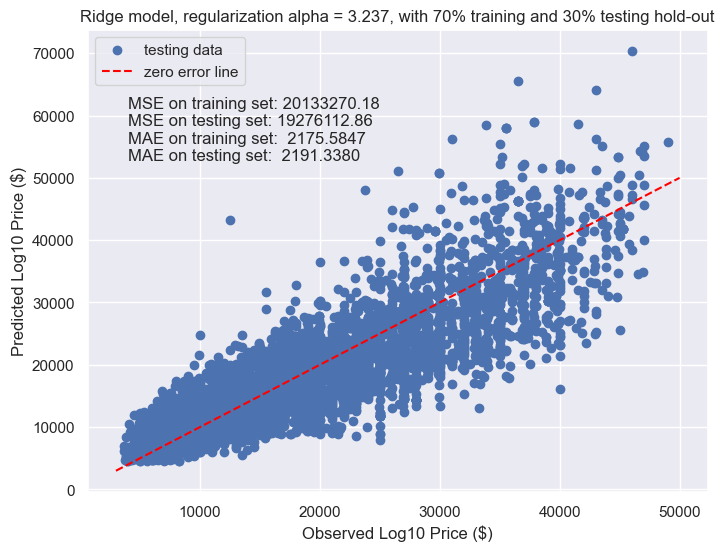

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.scatter(np.log10(yt_test), np.log10(pipe3.predict(Xt_test)))
# ax.text(3.6, 4.6, string_score)
# ax.plot( [3.5, 4.8], [3.5, 4.8], ls="--", c="red" )

ax.scatter(yt_test, pipe3.predict(Xt_test), label='testing data')
ax.text(4000, 50000, string_score)
ax.plot( [3000, 50000], [3000, 50000], ls="--", c="red", label="zero error line" )
ax.set_title(f'Ridge model, regularization alpha = {grid.best_params_["ridge__alpha"].round(3)}, with 70% training and 30% testing hold-out')
ax.set_xlabel("Observed Log10 Price ($)")
ax.set_ylabel("Predicted Log10 Price ($)")
ax.legend()
plt.show()

 We confirm that TransformedTargetRegressor is equivalent with transforming the y-target using log10(y) and 10**(y).

### <a name="variability">4.(D) Evaluation - Coefficient Importance and Variability Analysis</a>

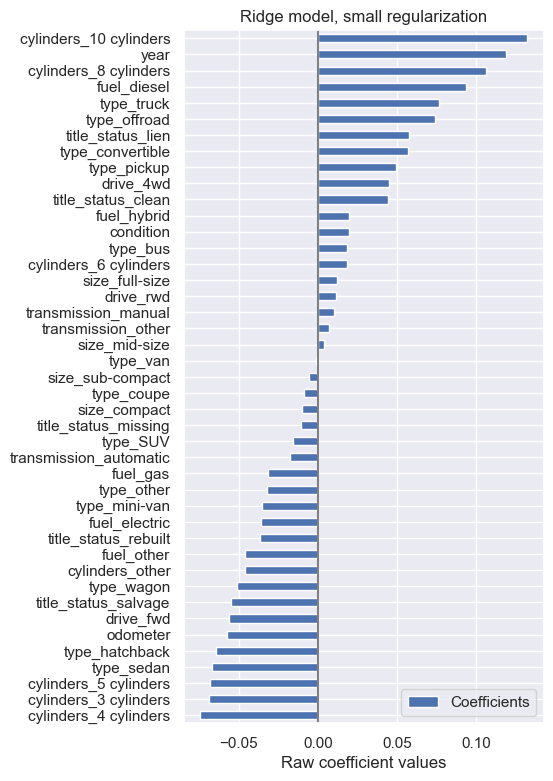

In [48]:
# create dataframe of coefs and plot
#
feature_names = pipe3[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe3[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs_sorted = coefs.sort_values('Coefficients', ascending=True)

coefs_sorted.plot.barh(figsize=(6, 9))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.show()

This plot is exactly the same as above with the Ridge regression coefs

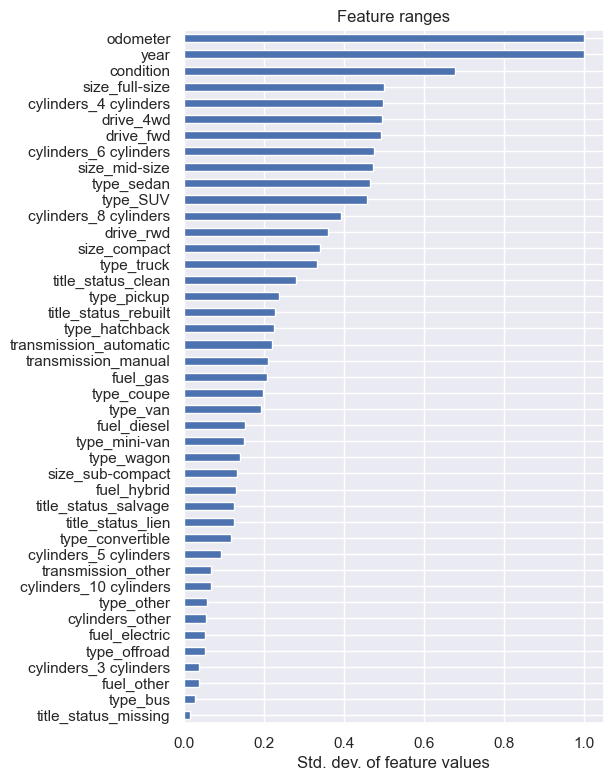

In [49]:
# create dataframe of coefs standard deviations and plot
#
xx = pipe3[:-1].transform(Xt_train)
X_train_preprocessed = pd.DataFrame( xx.toarray(), columns=feature_names )
X_train_preprocessed_std  = X_train_preprocessed.std(axis=0).sort_values()
#
X_train_preprocessed_std.plot.barh(figsize=(7, 9))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

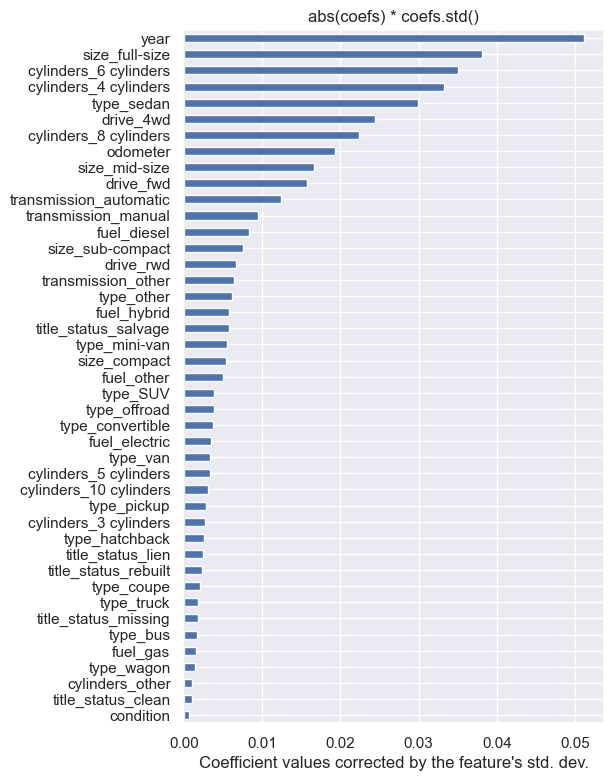

In [50]:
# Coefficient importance = Scale coefs by standard deviations and plot 
#
cx = pipe3[-1].regressor_.coef_
stdx = X_train_preprocessed_std
data = abs(cx) * stdx
coefs = pd.DataFrame( data, columns=["Coefficient importance"], index=feature_names )
coefs_sorted = coefs.sort_values("Coefficient importance")

coefs_sorted.plot(kind="barh", figsize=(7, 9), legend=False)
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("abs(coefs) * coefs.std()")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [51]:
### do k-fold cross validation to examine coefs variability
###
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=32)

cv_model = cross_validate(
    pipe3,
    Xt,
    yt,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

In [52]:
coefs_variable = pd.DataFrame(
    [pipe3[-1].regressor_.coef_ for pipe3 in cv_model["estimator"]], columns=feature_names
)
#coefs_variable.head(20)

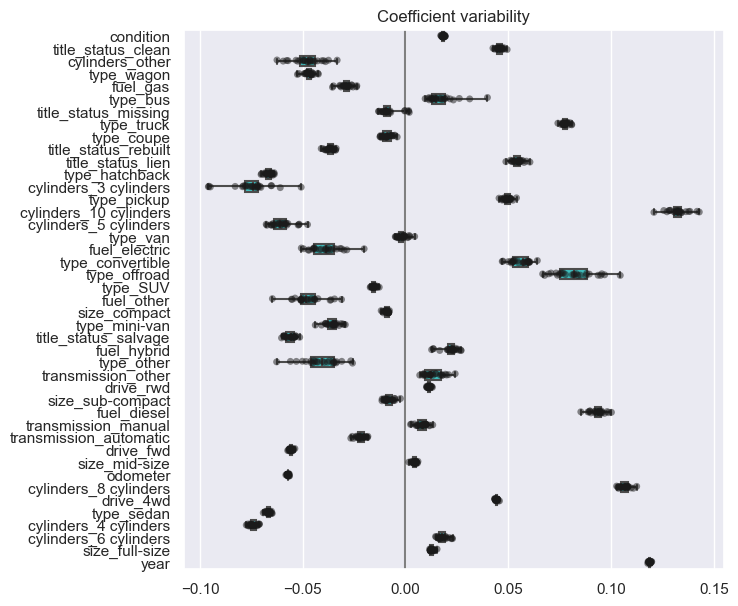

In [53]:
plt.figure(figsize=(9, 7))
order_list = coefs_sorted.index.tolist()

sns.stripplot(data=coefs_variable, orient="h", color="k", alpha=0.5, order=order_list )
sns.boxplot(data=coefs_variable, orient="h", color="cyan", saturation=0.5, whis=10, order=order_list )
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

We identify variability in coefficients that may not be well resolved.  These include categories (fuel_other, type_other, cylinder_other) that involve other selections that may not be well represented in the dataset. Also, less represented features like 3-cylinders, offroad, bus, fuel_electric may not be well represented.

Implications to used car business - The model's coefficients for well represented features seem stable.  The model indicates so logical expectations that vehicles that are specialized (e.g., offroad, truck) or have more power rank higher with positive coefficients leading to higher value while economy vehicles with lower power rank lower leading to decrease in vehicles resale value.

### <a name="residualanalysis">4. (E) Evaluation - Residual Analysis</a>

We compare residuals from Ridge model predictions with features included in the model and some that were left out to evaluate model performance and directions for model improvement  

In [54]:
# recreate dataframe used in regression for prediction
#
features = ['year', 'condition', 'cylinders', 'fuel', 'odometer', 
            'title_status', 'transmission', 'drive', 'size', 'type']
Xp = df_filtered[features]
#yp = df_filtered['price']
yp = np.log10( df_filtered['price'] )
# Xp.info()
# yp.describe()

In [55]:
# add additional columns to dataframe
#
Xp['predict'] = (10**best_model.predict(Xp)).round(2)
Xp['price'] = 10**yp
Xp['residual'] = Xp['price'] - Xp['predict']
#Xp.info()
#Xp

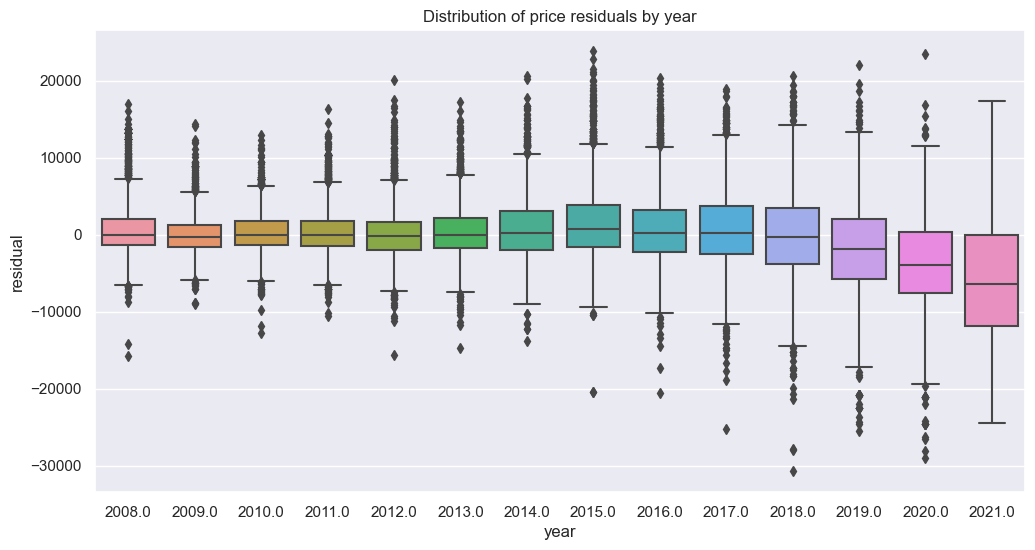

In [56]:
## check for residual trends by year
#
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=Xp, x="year", y="residual" ).set(title='Distribution of price residuals by year')
plt.show()

Note that we identify that there is increasing misfit with year for used cars that are only 1 to 2 years old.  This indicates that we may need to keep all data of cars by age of sale instead of time in years. 

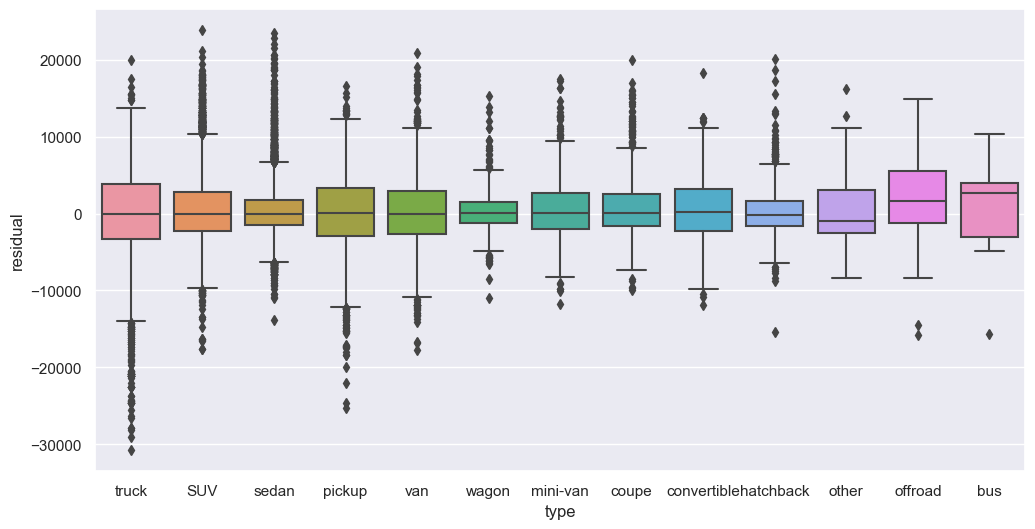

In [57]:
## check for residual trends by vehicle type
#
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(data=Xp, x="type", y="residual" )
plt.show()

merge the original dataframe with the residuals and plot by state

In [58]:
#Xp.info()
Xdrop = Xp.drop(columns=['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type'])
df_merge = pd.merge(df_filtered, Xdrop, left_index=True, right_index=True)
#df_merge.head()
#df_merge.info()

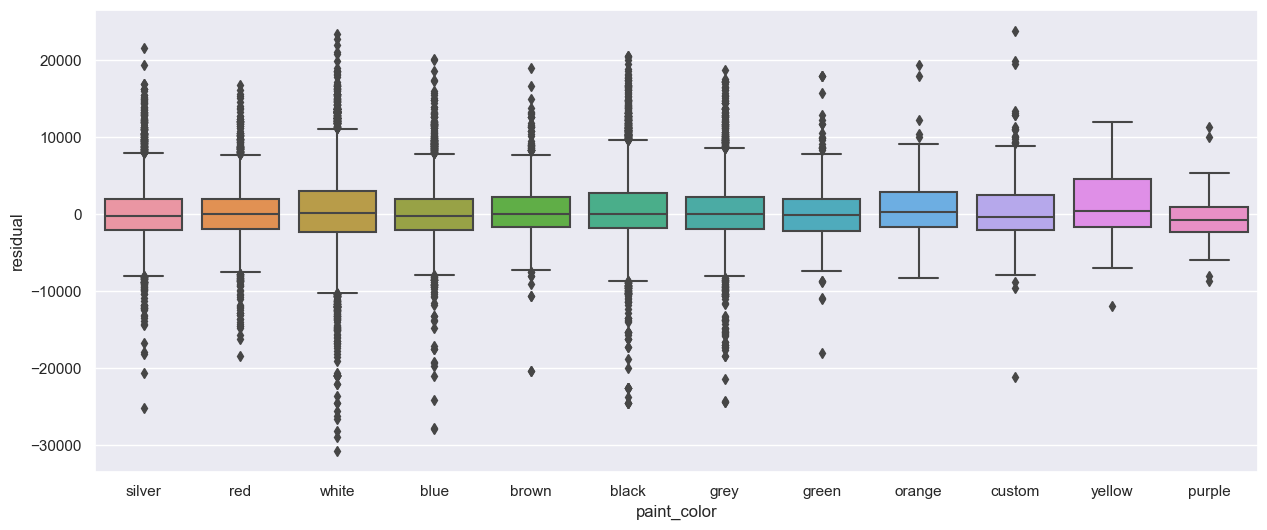

In [59]:
### visually there is little relationship between price residual and paint_color feature
###
sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(data=df_merge, x="paint_color", y="residual" )
plt.show()

In [60]:
# resid_by_color = df_merge.groupby(by='paint_color')[['paint_color', 'residual']].median().sort_values(by='residual')
# resid_by_color.plot.bar()

In [61]:
## group all the residuals by state and compute the mean residual. Sort states by mean residuals. 
##
resid_by_state = df_merge.groupby(by='state')[['state', 'residual']].mean().sort_values(by='residual', ascending=False)

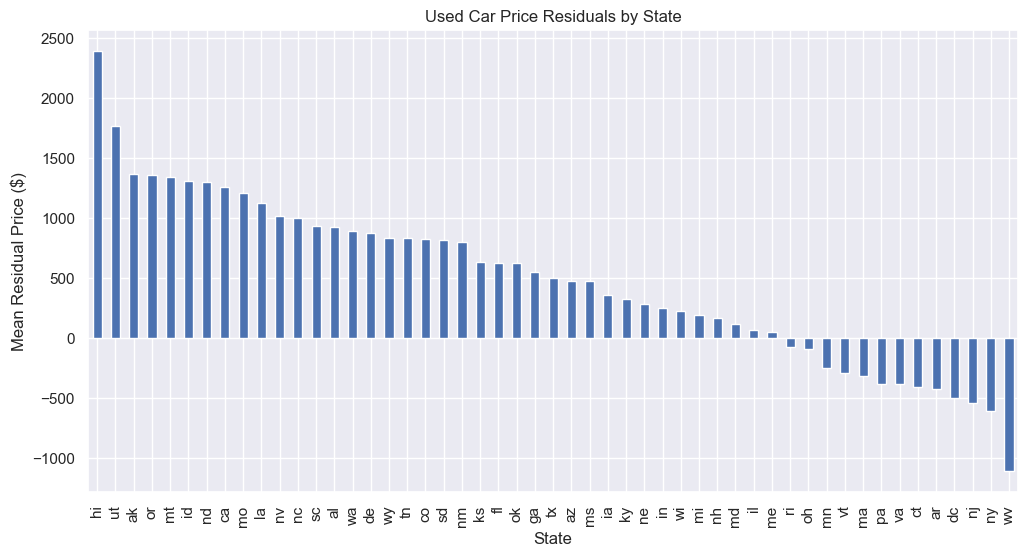

In [62]:
fig, ax = plt.subplots(figsize=(12,6))
resid_by_state.plot.bar(ax=ax, legend=False)
ax.set_xlabel('State')
ax.set_ylabel('Mean Residual Price ($)')
ax.set_title('Used Car Price Residuals by State')
fig.show()

As expected, states HI, AK, and CA have more expensive used cars by \\$ 2000 to \\$ 1000.  The cost of living in these states are higher.  UT, OR, MT, ND, MO and LA are interesting states where vehicle prices are higher.  Perhaps this is due to the fact that trucks are common in the western US, which are more expensive. West Virgina is the state where used cars are cheaper by \\$1000

## <a name="deployment">5. Deployment</a>

### <a name="direct">5. (A) We perform a direct application of regression model for two example cars.</a>

Comparison of the model to kbb.com with two example cars:
<ol type="1">
<li>
<a href="https://www.kbb.com/toyota/tacoma-double-cab/2015/prerunner-pickup-4d-5-ft/?category=pickup&condition=verygood&intent=buy-used&mileage=96322&options=10879479%7Ctrue%7C6059907%7Ctrue%7C6060302%7Cfalse%7C6059999%7Ctrue&pricetype=private-party&vehicleid=402400">kbb.com link to 2015 Toyota Tacoma Pickup Truct with 96k mi</a>
</li>
<li>    
<a href="https://www.kbb.com/honda/fit/2013/hatchback-4d/?category=hatchback&condition=good&intent=buy-used&mileage=113035&options=6520167%7Ctrue&pricetype=private-party&vehicleid=378827">kbb.com link to 2013 Honda fit subcompact hatchback with 113k mi</a>
    </li>
    </ol>

<P>The kbb.com price ranges from these links are entered into a DataFrame and run through the model to make predictions.
 

In [63]:
# A 2015 Toyota Tacoma Pickup Truct with 96k mi
df1 = pd.DataFrame( data={'year': 2015, 
                         'condition': 'excellent', 
                         'cylinders': '6 cylinders',
                         'fuel' : 'gas', 
                         'odometer': 96322.0,
                        'title_status' : 'clean', 
                        'transmission' :'automatic',
                        'drive' : 'rwd',
                        'size' : 'full-size',
                        'type' : 'truck', 
                         'kbb_low': 19672,
                         'kbb_hi': 22485, 
                          'predict_price': '0', 'regression': 'ridge' }, index=[1] )

# A 2013 Honda fit subcompact hatchback with 113k mi
df2 = pd.DataFrame( data={'year': 2013, 
                         'condition': 'fair', 
                         'cylinders': '4 cylinders',
                         'fuel' : 'gas', 
                         'odometer': 113035.0,
                        'title_status' : 'clean', 
                        'transmission' :'automatic',
                        'drive' : 'fwd',
                        'size' : 'sub-compact',
                        'type' : 'hatchback',
                        'kbb_low' : 6249,
                         'kbb_hi' : 7748,
                         'predict_price': '0', 'regression': 'ridge' }, index=[2]  )

df = pd.concat([df1,df2,df1,df2], ignore_index=True)
df['predict_price'] = df.predict_price.astype(float)
# df

In [64]:
### Comparisons with KBB: Ridge regression model
###
df.iloc[0,13] = "ridge"
df.iloc[1,13] = "ridge"
df.iloc[0,12] = (10**best_model.predict(df.iloc[[0]])).round(0)
df.iloc[1,12] = (10**best_model.predict(df.iloc[[1]])).round(0)

### Comparisons with KBB: LASSO regression model
###
df.iloc[2,13] = "lasso"
df.iloc[3,13] = "lasso"
df.iloc[2,12] = (10**best_model2.predict(df.iloc[[2]])).round(0)
df.iloc[3,12] = (10**best_model2.predict(df.iloc[[3]])).round(0)
df

,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,kbb_low,kbb_hi,predict_price,regression
0,2015,excellent,6 cylinders,gas,96322.0,clean,automatic,rwd,full-size,truck,19672,22485,21588.0,ridge
1,2013,fair,4 cylinders,gas,113035.0,clean,automatic,fwd,sub-compact,hatchback,6249,7748,7515.0,ridge
2,2015,excellent,6 cylinders,gas,96322.0,clean,automatic,rwd,full-size,truck,19672,22485,21572.0,lasso
3,2013,fair,4 cylinders,gas,113035.0,clean,automatic,fwd,sub-compact,hatchback,6249,7748,7552.0,lasso


The above application of two example vehicles show that the model works well in comparison with Kelly Blue Book (kbb.com) low and high value range. 

In conclusion, 

### <div id="keyfindings"><a name="keyfindings">5.(B) Key findings:</a></div>

1. Value of vehicles decrease with increasing age and higher odometer readings. We also observe an inverse relation between vehicle year and odometer. At an age of ten years and older, car values flatten out at less than \\$10,000. This is also where the odometer readings flatten out at approximately 110,000 miles.

2. The regression model indicates that vehicles which are specialized (e.g., off-road, truck) or have more power (cylinders > 6), rank higher with positive coefficients leading to increase value while economy vehicles with lower power rank lower leading to a decrease in vehicle's resale value. In other words, consumers want fun vehicles with more power. 

3. The car features year, cylinders, and odometer were the most important.

4. We identify some variability in several coefficients that indicate that they are not well resolved. These include 'other' categories (e.g., fuel_other, type_other, cylinder_other) that may not be well represented in the dataset. Also, less represented features like 3-cylinders, off-road, bus, fuel_electric may not be well represented in the dataset.

5. We demonstrate that for two example vehicles (2013 Honda Fit and 2015 Toyota Tacoma) that the model predicts the value of the vehicle within the range of the Kelly Blue Book value (kbb.com). This demonstrates the usefulness of the model.

### <a name="implications">5. (C) What does this mean for implications in fine tuning inventory?</a>

1. Age and year play an important role. Values of cars flatten out after 10 years or 110k miles. Dealers may want to adjust inventory to maximize profits accordingly.

2. Consumers want fun (off-road, trucks, four-wheel-drive) and powerful (10,8,6 cylinder) vehicles. Vehicles with these features are valued more. Dealers may want to stock these kinds of cars as opposed to vehicles that have negative coefficients. These tended to be more economy or budget cars with less powerful engines.

### <a name="future">5. (D) Next steps, future directions, and recommendations:</a>

<ol type="1">
<li>We recommend further examination of the regression residuals group by the following to check for trends:

<ol type="A">
<li>region</li>
<li>model and make</li>
<li>color</li>
</ol>
<P>
These features were not used in the regression. If trends exist, then future work could include adding these.

<li>Revisit the dataset in a few years to see if there is an increase in value for fuel efficient vehicles due to gas inflation.</li>

<li>We would like to further understand why the model has more misfit for newer used cars (1 to 2 years old). As above, it is possible that the Covid-19 pandemic has injected some nonlinearity to the used car market with supply chain issues.  Improving prediction can help pricing newer used cars which will have more value.</li>
</ol>